# 🧠 COVID-19 ICU Admission Prediction - Brazilian Hospital Data


This project analyzes ICU admission likelihood for hospitalized COVID-19 patients using medical records from Brazilian hospitals. We compare multiple classification models and assess performance based on accuracy, recall, AUC, and other metrics.

It includes:
- Data preprocessing
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model training and evaluation
- Model interpretability using SHAP


## 📦 Import Required Libraries

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
warnings.filterwarnings('ignore')
%matplotlib inline


## 📂 Load and Preprocess Dataset

In [15]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel("Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

# Drop columns with more than 50% missing values
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.5].index
df_cleaned = df.drop(columns=cols_to_drop)

# Drop identifier column (not useful for prediction)
df_cleaned = df_cleaned.drop(columns=['PATIENT_VISIT_IDENTIFIER'])

# Convert object columns to categorical codes
df_cleaned['AGE_PERCENTIL'] = df_cleaned['AGE_PERCENTIL'].astype('category').cat.codes
df_cleaned['WINDOW'] = df_cleaned['WINDOW'].astype('category').cat.codes

# Fill missing values with median for numeric columns
df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# Check final shape
print("Shape after cleaning:", df_cleaned.shape)


Shape after cleaning: (1925, 50)


In [22]:
df_cleaned.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0
1,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0
2,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,2,0
3,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-0.984944,-0.989822,-1.000000,-1.000000,-1.000000,3,0
4,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,4,1


## 📊 Exploratory Data Analysis

---



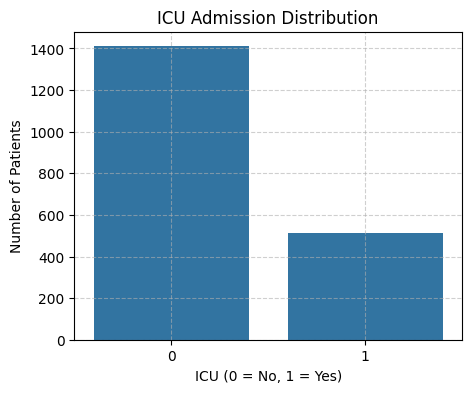

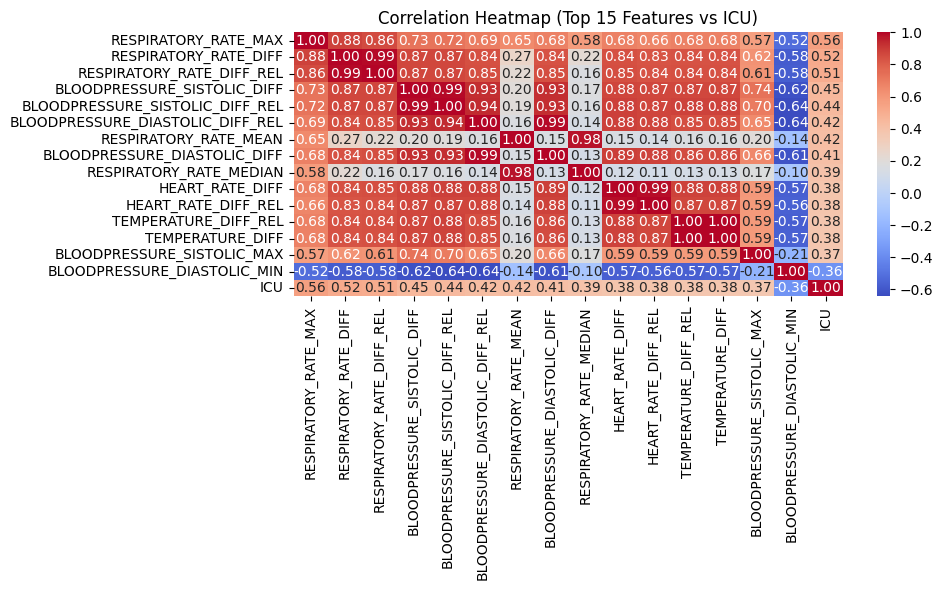

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot ICU admission distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='ICU', data=df_cleaned)
plt.title("ICU Admission Distribution")
plt.xlabel("ICU (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Correlation with ICU target
corr_with_icu = df_cleaned.corr()['ICU'].abs().sort_values(ascending=False)

# Display top 15 features most correlated with ICU
top_corr_features = corr_with_icu.index[1:16]
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[top_corr_features.tolist() + ['ICU']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Top 15 Features vs ICU)")
plt.tight_layout()
plt.show()


## 🤖 Model Training & Evaluation


In [24]:
# Feature Selection (using top correlated features)
selected_features = top_corr_features.tolist() + ['ICU']  # Include the target variable
X = df_cleaned[selected_features].drop(columns=['ICU'])
y = df_cleaned['ICU']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1540, 15)
Shape of X_test: (385, 15)
Shape of y_train: (1540,)
Shape of y_test: (385,)


In [25]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

results = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = auc(*roc_curve(y_test, y_proba)[:2])
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'AUC': auc_score
    })

results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(results_df)


[LightGBM] [Info] Number of positive: 412, number of negative: 1128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267532 -> initscore=-1.007178
[LightGBM] [Info] Start training from score -1.007178
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
3                  SVC  0.883117   0.914286  0.621359  0.739884  0.882807
2        Random Forest  0.862338   0.820513  0.621359  0.707182  0.881946
0  Logistic Regression  0.872727   0.950000  0.553398  0.699387  0.864043
4             LightGBM  0.854545   0.770115  0.650485  0.705263  0.853921
1        Decision Tree  0.836364   0.738095  0.601942  0.663102  0.719910


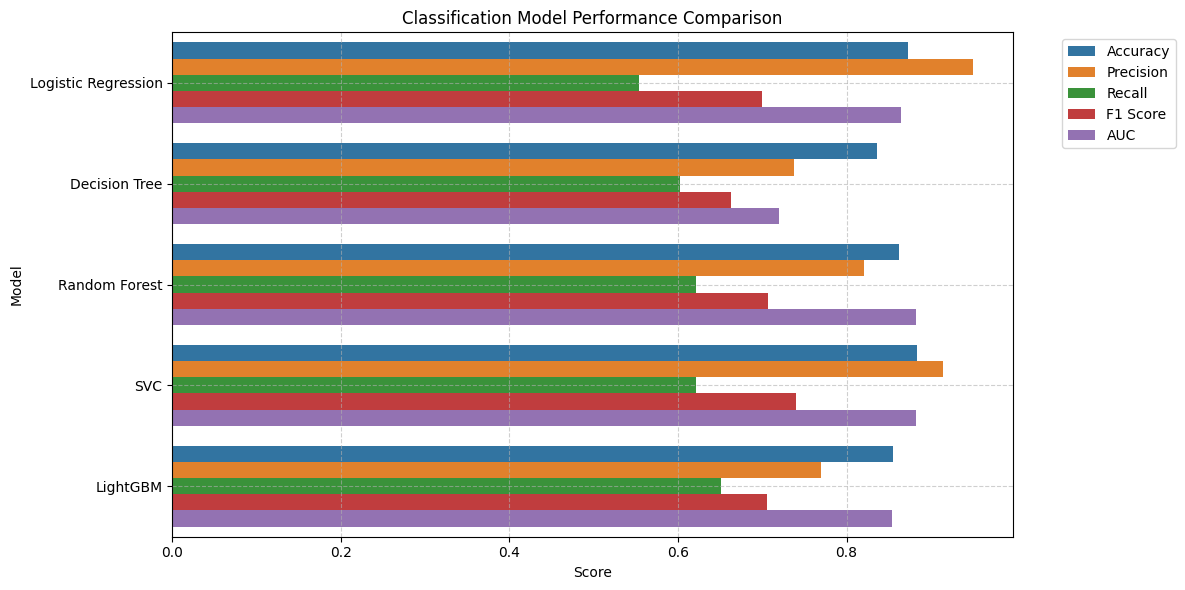

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame of results (from your output)
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'LightGBM'],
    'Accuracy': [0.872727, 0.836364, 0.862338, 0.883117, 0.854545],
    'Precision': [0.950000, 0.738095, 0.820513, 0.914286, 0.770115],
    'Recall': [0.553398, 0.601942, 0.621359, 0.621359, 0.650485],
    'F1 Score': [0.699387, 0.663102, 0.707182, 0.739884, 0.705263],
    'AUC': [0.864043, 0.719910, 0.881946, 0.882807, 0.853921]
})

# Melt for plotting
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Score', y='Model', hue='Metric')
plt.title('Classification Model Performance Comparison')
plt.xlabel('Score')
plt.ylabel('Model')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# 🧠**Model Comparison & Interpretation**


- **SVC** had the best **Accuracy (88%)**, **F1 Score**, and **AUC (0.88)**, making it the most balanced model overall.
- **Logistic Regression** had the **highest Precision (95%)**, meaning it made fewer false ICU predictions.
- **LightGBM** had the **best Recall (65%)**, catching more true ICU patients — this is vital in healthcare applications where **missing critical cases is dangerous**.
- **Random Forest** performed consistently across all metrics.
- **Decision Tree** was the simplest model, but slightly less effective overall.

> ✅ **Conclusion**: While SVC was the strongest performer overall, **LightGBM** is valuable for its **recall and interpretability**, especially in high-stakes ICU triage scenarios.



## 🤖 Train LightGBM Model

In [27]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 408, number of negative: 1132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1912
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264935 -> initscore=-1.020474
[LightGBM] [Info] Start training from score -1.020474


## 📈 Evaluate Model Performance

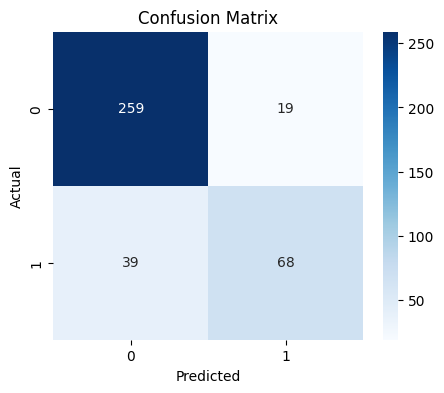

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       278
           1       0.78      0.64      0.70       107

    accuracy                           0.85       385
   macro avg       0.83      0.78      0.80       385
weighted avg       0.84      0.85      0.84       385



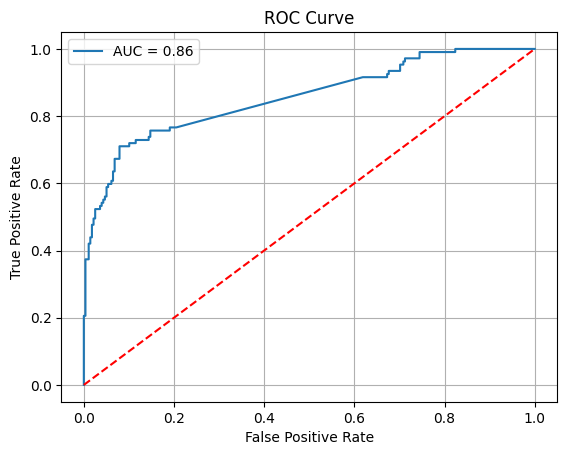

In [28]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## 🔍 Feature Importance (Top 15)

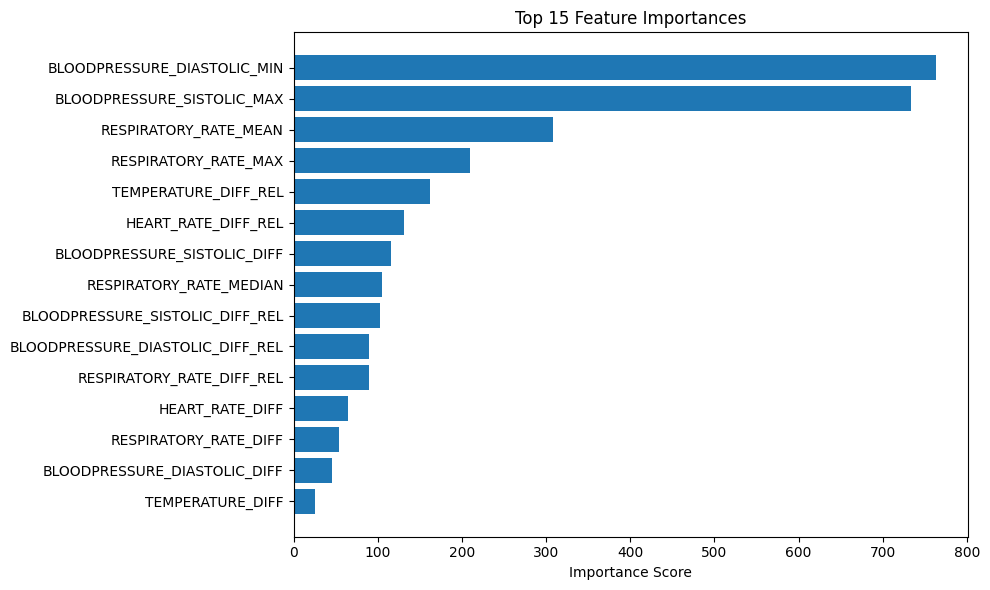

In [29]:

importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.barh(range(top_n), importances[top_indices][::-1], align='center')
plt.yticks(range(top_n), [features[i] for i in top_indices][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## 🧠 SHAP Analysis for Model Interpretability

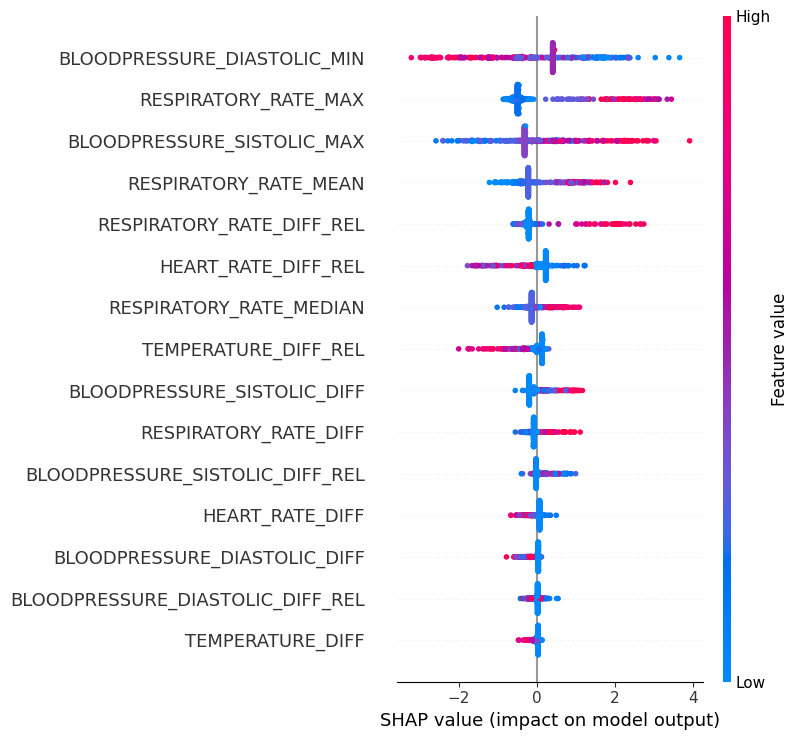

In [30]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


## ✅ Conclusion


- The LightGBM model performed well with strong classification metrics and AUC.
- Vitals and lab features were most predictive of ICU admission.
- SHAP analysis provides interpretability by showing feature influence on predictions.
- This model can aid hospitals in identifying high-risk patients earlier.
